In [1]:
import las2 as las
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def read_well(well_path):
    data = las.read(well_path)
    for i in range(len(data['curve'])):
        if data['curve'][i]['mnemonic'] == 'DEPTH':
            depth = data['data'][i]
        elif data['curve'][i]['mnemonic'] == 'GR':
            gr = data['data'][i]
        elif data['curve'][i]['mnemonic'] == 'NPHI':
            nphi = data['data'][i]
        elif data['curve'][i]['mnemonic'] == 'RHOB':
            rhob = data['data'][i]
        elif data['curve'][i]['mnemonic'] == 'Lith_new':
            lit = data['data'][i]
    return depth, gr, nphi, rhob, lit

In [7]:
well_path = "../data/7-MP-28D-BA.las"
depth, gr, nphi, rhob, lit = read_well(well_path)

In [31]:
sand = np.zeros(len(lit))
slury = np.copy(sand)
siltite = np.copy(sand)
shale = np.copy(sand)

for i in range(len(lit)):
    if lit[i] == 49:
        sand[i] = 49
    elif lit[i] == 25:
        slury[i] = 25
    elif lit[i] == 54:
        siltite[i] = 54
    elif lit[i] == 57:
        shale[i] = 57

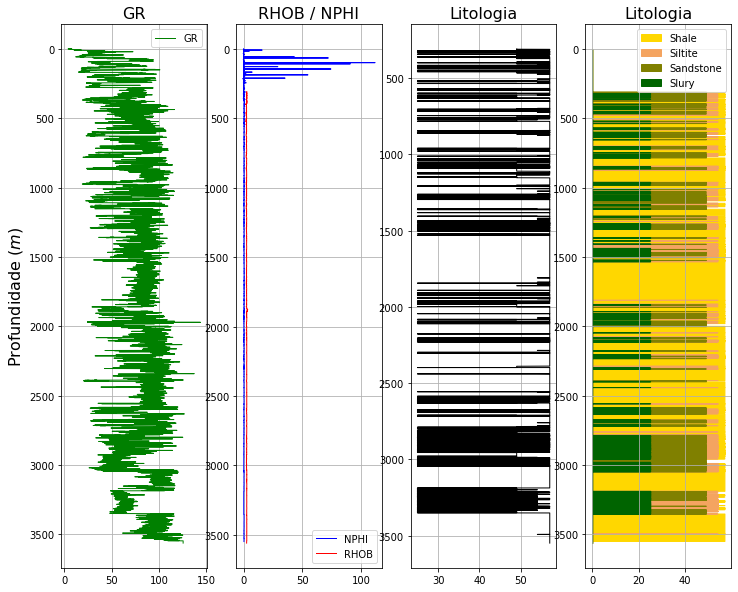

In [32]:
### Graficos

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4) # 4 cruvas = 4 subplots
fig.set_size_inches(12, 10) # tamanho da figura | polegadas

#_____________________________________________________#

ax1.plot(gr,depth,'-g',linewidth = 1,label='GR')
# (eixo x, eixo y, cor e tipo, comprimento da curva, legenda )
#ax1.plot(well_28D[3],well_28D[0],'-k',linewidth = 1,label='BS')
#ax1.plot(well_28D[5],well_28D[0],'-k',linewidth = 1,label='CAL')
ax1.invert_yaxis()
# inverte o eixo y
ax1.grid()
# adiciona o 'grid' ou malha de fundo
ax1.set_ylabel('Profundidade ($m$)', fontsize=16)
# o que vai ser escrito no eixo y
ax1.set_title('GR', fontsize=16)
# titulo do 'track' ou do grafico com tamanho de letra 16
ax1.legend()

#_____________________________________________________#

ax2.plot(nphi,depth,'-b',linewidth = 1,label='NPHI')
ax2.plot(rhob,depth,'-r',linewidth = 1,label='RHOB')
ax2.invert_yaxis()
ax2.grid()
ax2.set_title('RHOB / NPHI', fontsize=16)
ax2.legend()
#_____________________________________________________#

ax3.plot(lit,depth,'-k',linewidth = 1,label='Litologia')
ax3.invert_yaxis()
ax3.grid()
ax3.set_title('Litologia', fontsize=16)

#_____________________________________________________#

ax4.fill_betweenx(depth, shale, step = 'pre', color = 'gold', label = 'Shale')
ax4.fill_betweenx(depth, siltite, step = 'pre', color = 'sandybrown', label = 'Siltite')
ax4.fill_betweenx(depth, sand, step = 'pre', color = 'olive', label = 'Sandstone')
ax4.fill_betweenx(depth, slury, step = 'pre', color = 'darkgreen', label = 'Slury')
ax4.invert_yaxis()
ax4.legend()
ax4.set_title('Litologia', fontsize=16)
ax4.grid()

#ax4.plot(VSH_GR_DP1,prof_DP1,'-g',linewidth = 1,label='VSH_GR')
#ax4.plot(VSH_ND_DP1,prof_DP1,'-b',linewidth = 1,label='VSH_NR')
#ax4.invert_yaxis()
#ax4.grid()
#ax4.set_title('VSH', fontsize=16)
#ax4.legend(loc=2)
# adiciona a posicao da legenda

plt.show()